In [7]:
    
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import time
from scipy.ndimage import gaussian_filter

class Helpers(): 
    def __init__(self) -> None:
        self.path_dir  = None
        self.path_data = dict()
        self.data = dict()
        self.df = pd.DataFrame()
        pass
    
    def time_now()->float:
        return time.time()
    
    def read_single_file_to_df(self, file:str = "", sep:str = "\t", headers:int = 0)->pd.DataFrame:
        if os.path.isfile(file):
            return pd.read_csv(self.path_dir[0],sep=sep,header=headers)
        
        if self.path_dir is None:
            # self.path_dir = os.path.dirname(os.getcwd())
            self.path_dir = os.path.join(os.getcwd(), '../data')
            self.path_dir = self.__get_file_path_from_ext__(self.path_dir,ext="tsv")

        self.df = pd.read_csv(self.path_dir[0],sep=sep,header=headers)
        return self.df
        
    def __get_file_path_from_ext__(self, path_dir:str, ext:str)->str:
       return glob.glob(os.path.join(path_dir, f"*.{ext}"))
       
    def read_data(self)->None:
        if self.path_dir is None:
            current_file_path = os.path.abspath(__file__)
            current_dir = os.path.dirname(current_file_path)
            self.path_dir = os.path.dirname(current_dir)
            self.path_dir = os.path.join(self.path_dir, 'data')
            
        # Iterate over all items in self.path_dir
        for item in os.listdir(self.path_dir):
            # Construct the full path to the item
            item_path = os.path.join(self.path_dir, item)
            self.path_data[item] = pd.DataFrame()

            # Check if the item is a directory
            if os.path.isdir(item_path):
                # Find all .txt files in the directory
                txt_files = glob.glob(os.path.join(item_path, '*.txt'))
                # Iterate over each file
                for file_path in txt_files:
                    self.path_data[item] = pd.read_csv(file_path)
            else:
                print(f"{item_path} is not a directory")
                
class Plot():
    def __init__(self)->None:
        pass

    def heat_map(self,df:pd.DataFrame = None, n_bins:int = 100)->None:
        # 2d coords to plot 
        columns_to_extract = [
        'combined_gaze_direction_norm_x', 
        'combined_gaze_direction_norm_y'
        ]
        
        # make sure df is already pre-processed
        data = Helpers().read_single_file_to_df(headers=9)
        time_stamps = data['time_querycounter']  
        coords = data[columns_to_extract]
        coords = PreProcess().replace_minus_one_with_nan(coords)
        coords = PreProcess().filter(coords,0.1)
        # df_coord = PreProcess().replace_minus_one_with_nan(df)
        # time_stamps = df['time_querycounter']  
        # df_coord = df[columns_to_extract]
    
        x_bins = np.linspace(-1, 1, n_bins + 1)
        y_bins = np.linspace(-1, 1, n_bins + 1)

        # get x,y coords (gaze direction is normalized)
        x_data = coords[:,0]
        y_data = coords[:,1]
        # x_data = np.clip(coords.iloc[:, 0], -1, 1)
        # y_data = np.clip(coords.iloc[:, 1], -1, 1)
        
        # create histogram
        time_histogram = np.zeros((n_bins, n_bins))
        fs = data['time_querycounter'].diff().mean()

        # Assigning time spent to the appropriate bins
        time_dur = 0
        for x, y, t in zip(x_data, y_data, time_stamps):
            x_idx = np.digitize(x, x_bins) - 1  # Get the bin index for x
            y_idx = np.digitize(y, y_bins) - 1  # Get the bin index for y
            if 0 <= x_idx < n_bins and 0 <= y_idx < n_bins:
                time_histogram[y_idx, x_idx] += fs  # Add the time spent to the bin
                time_dur += fs

        # Plotting
        plt.figure(figsize=(8, 8))
        # cmap = 'Reds'
        cmap='viridis'
        plt.imshow(time_histogram, extent=[-1, 1, -1, 1], origin='lower', cmap=cmap)
        plt.colorbar(label='Time Spent in bin (s)')
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.title('2D Histogram of Time Spent in Coordinates')
        plt.show()
        
class PreProcess():
    def __init__(self) -> None:
        pass

    def filter(self,df:pd.DataFrame=None,sigma:int=3)->np.ndarray:
        if df is None:
            return np.ndarray()
        smoothed_matrix = gaussian_filter(df, sigma=sigma)
        return smoothed_matrix
    
    def normalize(self,x:int=np.ndarray)->np.ndarray:
        return 2 * (x - x.min()) / (x.max() - x.min()) - 1

    def replace_minus_one_with_nan(self,df:pd.DataFrame = None)->pd.DataFrame:
        if df is None: 
            print("gimme a dataframe pleases")
            return pd.DataFrame
        df_copy = df.copy()
        rows_with_minus_one = (df_copy == -1).any(axis=1)
        print(f"Replacing {rows_with_minus_one.sum()} rows with NaN")
        df_copy.loc[rows_with_minus_one] = np.nan
        return df_copy

Replacing 133882 rows with NaN


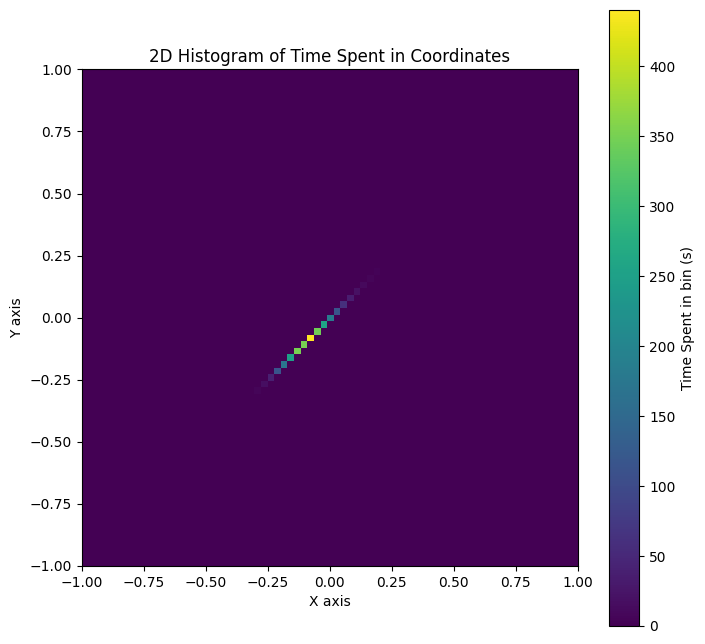

In [6]:
data = Helpers().read_single_file_to_df(headers=9)
Plot().heat_map()